In [94]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from interval import interval
import pandas as pd
from scipy.spatial import ConvexHull

In [95]:
def naive_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T  # shape (n_features, n_samples)
    y_intervals = [interval[y_l, y_u] for y_l, y_u in zip(y_lower, y_upper)]

    beta_naive = []
    for i in range(M.shape[0]):  # for each coefficient
        row = M[i]
        beta_j = interval[0, 0]
        for c, y_int in zip(row, y_intervals):
            beta_j += float(c) * y_int  # interval arithmetic
        beta_naive.append(beta_j)

    if x_grid is not None:
        beta0, beta1 = beta_naive
        y_min = []
        y_max = []
        for xg in x_grid:
            y_int = beta0 + beta1 * xg  # interval arithmetic
            y_min.append(y_int[0][0])
            y_max.append(y_int[0][1])
        return beta_naive, (np.array(y_min), np.array(y_max))
    
    return beta_naive



def actual_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T

    vertices = list(product(*zip(y_lower, y_upper)))
    beta_vertices = []
    for y_vertex in vertices:
        y_vertex = np.array(y_vertex)
        beta_vertex = M @ y_vertex
        beta_vertices.append(beta_vertex)

    if x_grid is not None:
        y_min, y_max = [], []
        for xg in x_grid:
            preds = [b[0] + b[1] * xg for b in beta_vertices]
            y_min.append(min(preds))
            y_max.append(max(preds))
        return beta_vertices, (np.array(y_min), np.array(y_max))
    
    return beta_vertices

def monte_carlo_sampling(X, y_lower, y_upper, n_samples=10000, x_grid=None):
    # Ensure numeric arrays
    y_lower = np.array(y_lower, dtype=float)
    y_upper = np.array(y_upper, dtype=float)

    M = np.linalg.inv(X.T @ X) @ X.T
    n_points = len(y_lower)

    # Generate all samples at once
    rng = np.random.default_rng()  # modern numpy random generator
    y_samples = rng.uniform(low=y_lower, high=y_upper, size=(n_samples, n_points))

    # Map to coefficients (linear map)
    beta_samples = y_samples @ M.T  # shape (n_samples, n_coeffs)

    if x_grid is not None:
        # Compute prediction intervals at all x_grid points
        x_grid = np.array(x_grid, dtype=float)
        # preds = beta0 + beta1 * x for all samples and all x_grid
        preds = beta_samples[:, 0][:, np.newaxis] + beta_samples[:, 1][:, np.newaxis] * x_grid[np.newaxis, :]
        y_min = np.min(preds, axis=0)
        y_max = np.max(preds, axis=0)
        return beta_samples, (y_min, y_max)

    return beta_samples




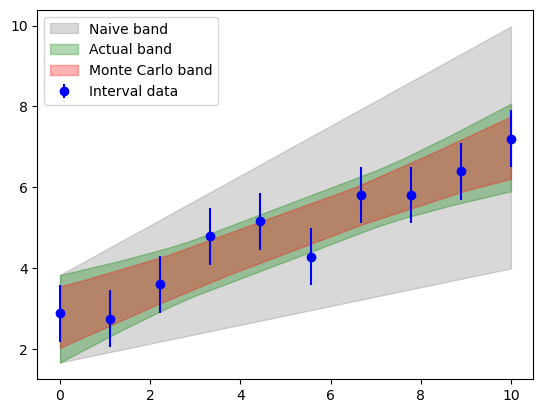

In [96]:
np.random.seed(0)

n = 10
x = np.linspace(0, 10, n)
X = np.vstack([np.ones(len(x)), x]).T

# "True" regression line
y_true = 2 + 0.5 * x  

# Add noise
noise = np.random.normal(0, 0.5, size=n)

# Create intervals: center ± width
y_obs = y_true + noise
interval_width = 0.7
y_lower = y_obs - interval_width
y_upper = y_obs + interval_width

# grid for plotting
x_grid = np.linspace(0, 10, 200)

beta_naive, (y_min_naive, y_max_naive) = naive_bounds(X, y_lower, y_upper, x_grid)

beta_actual, (y_min_actual, y_max_actual) = actual_bounds(X, y_lower, y_upper, x_grid)

beta_monte, (y_min, y_max) = monte_carlo_sampling(X, y_lower, y_upper, x_grid=x_grid)


plt.fill_between(x_grid, y_min_naive, y_max_naive, color='gray', alpha=0.3, label='Naive band')
plt.fill_between(x_grid, y_min_actual, y_max_actual, color='green', alpha=0.3, label='Actual band')
plt.fill_between(x_grid, y_min, y_max, color='red', alpha=0.3, label='Monte Carlo band')
plt.errorbar(x, (y_lower+y_upper)/2, yerr=(y_upper-y_lower)/2, fmt='o', color='blue', label='Interval data')
plt.legend()
plt.show()


In [97]:
# unpack naive intervals
beta0_int, beta1_int = beta_naive
beta0_low, beta0_high = beta0_int[0][0], beta0_int[0][1]
beta1_low, beta1_high = beta1_int[0][0], beta1_int[0][1]

# collect actual betas as array
beta_actual = np.array(beta_actual)  # shape (#vertices, 2)

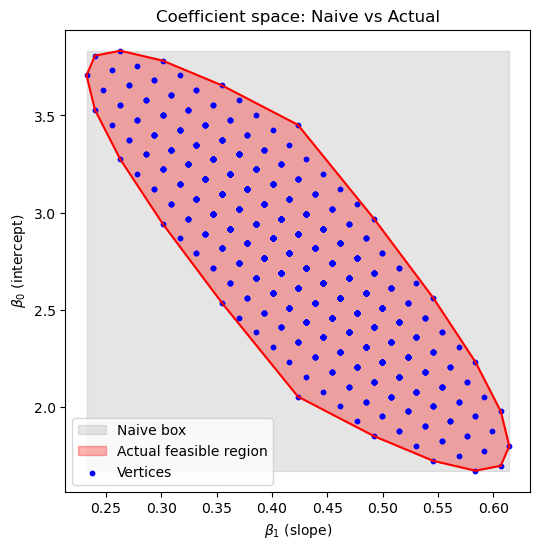

In [98]:
plt.figure(figsize=(6,6))

# naive box
plt.fill_between(
    [beta1_low, beta1_high], beta0_low, beta0_high,
    color="gray", alpha=0.2, label="Naive box"
)

# actual convex hull
hull = ConvexHull(beta_actual)
for simplex in hull.simplices:
    plt.plot(beta_actual[simplex,1], beta_actual[simplex,0], "r-")  # note: beta1 on x, beta0 on y

plt.fill(beta_actual[hull.vertices,1], beta_actual[hull.vertices,0], color="red", alpha=0.3, label="Actual feasible region")

# scatter actual betas
plt.scatter(beta_actual[:,1], beta_actual[:,0], color="blue", s=10, label="Vertices")

# labels
plt.xlabel(r"$\beta_1$ (slope)")
plt.ylabel(r"$\beta_0$ (intercept)")
plt.legend()
plt.title("Coefficient space: Naive vs Actual")
plt.show()

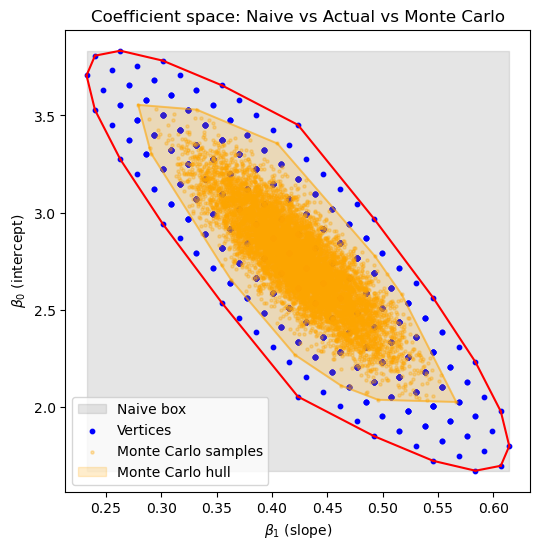

In [99]:
plt.figure(figsize=(6,6))

# naive box
plt.fill_between(
    [beta1_low, beta1_high], beta0_low, beta0_high,
    color="gray", alpha=0.2, label="Naive box"
)

# actual convex hull
hull_actual = ConvexHull(beta_actual)
for simplex in hull_actual.simplices:
    plt.plot(beta_actual[simplex,1], beta_actual[simplex,0], "r-")

# scatter actual vertices
plt.scatter(beta_actual[:,1], beta_actual[:,0], color="blue", s=10, label="Vertices")

# scatter Monte Carlo points
plt.scatter(beta_monte[:,1], beta_monte[:,0], color="orange", s=5, alpha=0.3, label="Monte Carlo samples")

# convex hull of Monte Carlo points
hull_monte = ConvexHull(beta_monte)
for simplex in hull_monte.simplices:
    plt.plot(beta_monte[simplex,1], beta_monte[simplex,0], "orange", alpha=0.5)
plt.fill(beta_monte[hull_monte.vertices,1], beta_monte[hull_monte.vertices,0], color="orange", alpha=0.2, label="Monte Carlo hull")

# labels
plt.xlabel(r"$\beta_1$ (slope)")
plt.ylabel(r"$\beta_0$ (intercept)")
plt.legend()
plt.title("Coefficient space: Naive vs Actual vs Monte Carlo")
plt.show()
